In [27]:
import numpy as np

def get_roi_centroids(image_segmentation):
    centroids = []
    for mask in image_segmentation['image_mask']:
        ys, xs = np.where(mask)
        x = np.mean(xs)
        y = np.mean(ys)
        centroids.append((x, y))
    return np.array(centroids)

centroids = get_roi_centroids(image_segmentation)
centroidX = centroids[:, 0]
centroidY = centroids[:, 1]

Conditioned neuron coordinate: [38.16666667 44.16666667]
Closest ROI is #17 at [42.17948718 20.41025641]


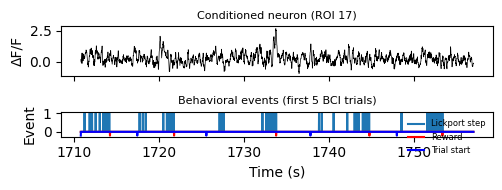

In [28]:
# Set smoothing window size (in frames); set to 0 to disable smoothing
smoothing_window = 10

# Grab the first non-null entry
x = bci['conditioned_neuron_x'].dropna().iloc[0]
y = bci['conditioned_neuron_y'].dropna().iloc[0]
conditioned_coord = np.array([x, y])*2
#conditioned_coord = np.array([164.25, 129.875])
print("Conditioned neuron coordinate:", conditioned_coord)

# Get centroids and match
centroids = get_roi_centroids(soma_segmentation)
roi_coords = np.stack((centroids[:, 0], centroids[:, 1]), axis=1)
conditioned_neuron = np.argmin(np.linalg.norm(roi_coords - conditioned_coord, axis=1))
print(f"Closest ROI is #{conditioned_neuron} at {centroids[conditioned_neuron]}")


# --- Step 2: Build binary time series ---
n_frames = dff.shape[0]
lickport_steps_ts = np.zeros(n_frames)
rewards_ts = np.zeros(n_frames)
trial_starts_ts = np.zeros(n_frames)

for _, row in bci.iterrows():
    try:
        trial_start_f = int(row['BCI_start_frame'])
    except:
        trial_start_f = int(row['start_frame'])

    # Trial start
    if trial_start_f < n_frames:
        trial_starts_ts[trial_start_f] = 1

    # Reward
    rt = row.get('BCI_reward_time', np.nan)
    if not np.isnan(rt):
        reward_f = trial_start_f + int(rt * frame_rate)
        if reward_f < n_frames:
            rewards_ts[reward_f] = 1

    # Zaber steps
    zsteps = row.get('BCI_zaber_steps', [])
    if isinstance(zsteps, (list, np.ndarray)):
        for tstep in zsteps:
            if not np.isnan(tstep):
                step_f = trial_start_f + int(tstep * frame_rate)
                if 0 <= step_f < n_frames:
                    lickport_steps_ts[step_f] = 1

# --- Step 3: Define frame range for first 5 trials ---
try:
    start_f = int(bci['BCI_start_frame'].iloc[0])
    stop_f  = int(bci['BCI_stop_frame'].iloc[4])
except:
    start_f = int(bci['start_frame'].iloc[42])
    stop_f  = int(bci['stop_frame'].iloc[46])
frame_range = slice(start_f, stop_f)
t = np.arange(start_f, stop_f) / frame_rate

# --- Step 4: Plot stacked subplots ---
fig, axs = plt.subplots(2, 1, figsize=(5, 2), sharex=True, height_ratios=[1, 0.5])

# Top: conditioned neuron
trace = dff[frame_range, conditioned_neuron]

# Apply boxcar smoothing if requested
if smoothing_window > 0:
    kernel = np.ones(smoothing_window) / smoothing_window
    trace = np.convolve(trace, kernel, mode='same')

axs[0].plot(t, trace, 'k', linewidth=0.5)

axs[0].set_ylabel('ΔF/F')
axs[0].set_title(f'Conditioned neuron (ROI {conditioned_neuron})', fontsize=8)

# Bottom: behavioral events
axs[1].plot(t, lickport_steps_ts[frame_range], label='Lickport step')
axs[1].plot(t, -rewards_ts[frame_range]/5, 'r', label='Reward')
axs[1].plot(t, -trial_starts_ts[frame_range]/5, 'b', label='Trial start')
axs[1].legend(fontsize=6, loc='upper right', frameon=False)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Event')
axs[1].set_title('Behavioral events (first 5 BCI trials)', fontsize=8)

plt.tight_layout()
plt.show()


In [29]:
# Conditioned neuron coordinate from old data
target_coord = np.array([107.3, 137.2])

# Get ROI centroids
centroids = get_roi_centroids(soma_segmentation)  # shape: (n_rois, 2)

# Compute Euclidean distance to each ROI
distances = np.linalg.norm(centroids - target_coord, axis=1)

# Find the index of the closest ROI
conditioned_neuron = np.argmin(distances)
print(f"Closest ROI to conditioned neuron is ROI #{conditioned_neuron} at {centroids[conditioned_neuron]}")


Closest ROI to conditioned neuron is ROI #168 at [106.70967742 141.70967742]


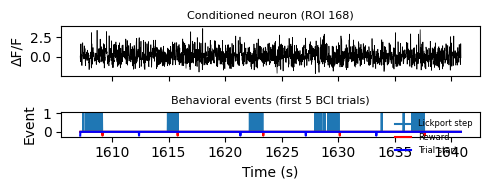

In [31]:
# Get frame range for the first 5 trials
start_f = int(bci['start_frame'].iloc[30])
stop_f  = int(bci['stop_frame'].iloc[34])
frame_range = slice(start_f, stop_f)
t = np.arange(start_f, stop_f) / frame_rate

# Extract trace of conditioned neuron
trace = dff[frame_range, conditioned_neuron]

# Plot
fig, axs = plt.subplots(2, 1, figsize=(5, 2), sharex=True, height_ratios=[1, 0.5])

# Top: conditioned neuron trace
axs[0].plot(t, trace, 'k', linewidth=0.5)
axs[0].set_ylabel('ΔF/F')
axs[0].set_title(f'Conditioned neuron (ROI {conditioned_neuron})', fontsize=8)

# Bottom: behavioral events
axs[1].plot(t, lickport_steps_ts[frame_range], label='Lickport step')
axs[1].plot(t, -rewards_ts[frame_range]/5, 'r', label='Reward')
axs[1].plot(t, -trial_starts_ts[frame_range]/5, 'b', label='Trial start')
axs[1].legend(fontsize=6, loc='upper right', frameon=False)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Event')
axs[1].set_title('Behavioral events (first 5 BCI trials)', fontsize=8)

plt.tight_layout()
plt.show()


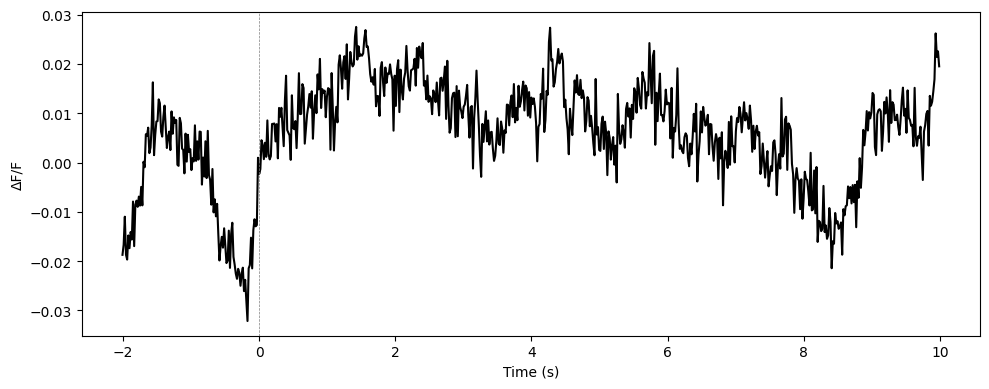

In [33]:
from scipy.stats import pearsonr
def mean_bin_plot(xx, yy, col, pltt, A, color):
    xx = np.reshape(xx, (-1, 1))
    yy = np.reshape(yy, (-1, 1))
    if len(color) == 0:
        color = 'bbbbbbb'
    if pltt < 4:
        pltt = 1
        A = 1
        #color = 'k'
    if col is None:
        col = 5

   
    x = xx
    y = yy / A

    a = np.isnan(x)
    x = x[~a]
    y = y[~a]

    a = np.sort(x, axis=0)
    b = np.argsort(x, axis=0)

    c, p = np.corrcoef(x[b], y[b])
    c = np.diag(c)
    p = np.diag(p)

    x = x[b]
    y = y[b]

    row = len(x) // col
    length = row * col
    x = np.reshape(x[:length], (col, row))
    y = np.reshape(y[:length], (col, row))

  
    X = np.nanmean(x, axis=1)
    Y = np.nanmean(y, axis=1)
    stdEr = np.nanstd(y, axis=1) / np.sqrt(row)

    if pltt == 1:
        
        plt.errorbar(X, Y, stdEr, marker='o', markersize=1,
                     color=color, markerfacecolor=color)

    r, p = pearsonr(X, Y)
    #print('p-value = ' + str(p))
    

    #plt.title('P = ' + str(P))
    return X, Y, p

import numpy as np
frame_rate = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].rate

def create_BCI_F_from_nwb(dff, bci, pre_frames, post_frames):
  
    n_neurons = dff.shape[1]
    trial_starts = bci['start_frame'].values
    n_trials = len(trial_starts)

    F = np.full((pre_frames + post_frames, n_neurons, n_trials), np.nan)

    for i, start in enumerate(trial_starts):
        # Only include trials with enough padding before and after
        if start - pre_frames < 0 or start + post_frames >= dff.shape[0]:
            continue
        F[:, :, i] = dff[start - pre_frames : start + post_frames, :]

    return F

pre_frames = int(round(2 * frame_rate))
post_frames = int(round(10 * frame_rate))
tsta = np.arange(-pre_frames, post_frames) / frame_rate

F = create_BCI_F_from_nwb(dff,  bci, pre_frames, post_frames)

# Assume F has shape (time, neurons, trials)
# First, define how many frames correspond to 1 second
baseline_frames = int(round(1 * frame_rate))

# Compute mean trace over trials
f = np.nanmean(F, axis=2)  # shape: (time, neurons)

# Subtract baseline (first second of activity) per cell
baseline = np.nanmean(f[:baseline_frames, :], axis=0)  # shape: (neurons,)
f = f - baseline  # broadcast subtraction

# Plot mean across neurons
plt.plot(tsta, np.nanmean(f, axis=1), 'k')
plt.xlabel('Time (s)')
plt.ylabel('ΔF/F')
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


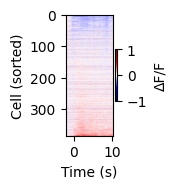

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Sort cells by mean response
b = np.argsort(np.nanmean(f, axis=0))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(2, 2))
im = ax.imshow(f[:, b].T, vmin=-1, vmax=1, aspect='auto', cmap='seismic')

# Time ticks at 0s and 10s
tick_locs = [np.argmin(np.abs(tsta - 0)), np.argmin(np.abs(tsta - 10))]
tick_labels = [0, 10]
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels)

# Axis labels
ax.set_xlabel('Time (s)')
ax.set_ylabel('Cell (sorted)')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.05, pad=0.04)
cbar.set_label('ΔF/F')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Before learning')

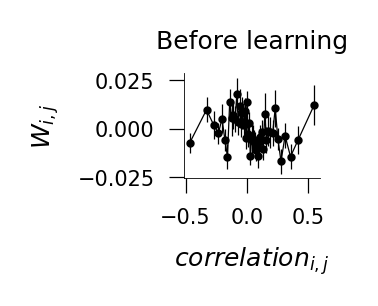

In [63]:
# Example: compute activity and correlations in post-learning window
k = np.nanmean(F[120:360, :, :], axis=0)  # shape: (n_neurons, n_trials)
cc = np.corrcoef(k)  # correlation matrix
#cc = k @ k.T

AMP = []
AMP.append(amp)
AMP.append(amp)
X, Y, Yo = [], [], []

for gi in range(stimDist.shape[1]):
    cl = np.where((stimDist[:, gi] < 30) & (AMP[0][:, gi] > 0.1) & (AMP[1][:, gi] > 0.1))[0]
    if len(cl) == 0:
        continue

    x = np.nanmean(cc[cl, :], axis=0)

    nontarg = np.where((stimDist[:, gi] > 30) & (stimDist[:, gi] < 1000))[0]
    y = AMP[1][nontarg, gi]

    X.append(x[nontarg])
    Y.append(y)

X = np.concatenate(X)
Y = np.concatenate(Y)


# Plot
plt.figure(figsize = (2,1))
plt.subplot(231)
mean_bin_plot(X, Y, 45, 1, 1, 'k')
plt.xlabel('$correlation_{i,j}$')
plt.ylabel('$W_{i,j}$')
plt.title('Before learning')



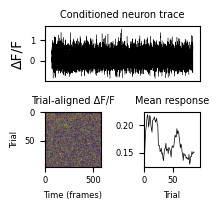

In [39]:
plt.figure(figsize=(2.2, 2.2))

# --- Top panel: full trace of conditioned neuron ---
plt.subplot(211)
start_f = int(bci['start_frame'].iloc[0])
stop_f  = int(bci['stop_frame'].iloc[F.shape[2]-1])
frame_range = slice(start_f, stop_f)
t = np.arange(start_f, stop_f) / frame_rate
t = t - t[0]
trace = dff[frame_range, conditioned_neuron]
kernel = np.ones(smoothing_window) / smoothing_window
trace = np.convolve(trace, kernel, mode='same')
plt.plot(t, trace, 'k', linewidth=0.25)
plt.ylabel('ΔF/F')
plt.title('Conditioned neuron trace', fontsize=7)
plt.xticks([])
plt.yticks(fontsize=6)

# --- Bottom left: trial-aligned heatmap ---
plt.subplot(223)
Fcn = F[pre_frames:, conditioned_neuron, :]  # time x trials
im = plt.imshow(Fcn.T, aspect='auto', vmin=0, vmax=1)
plt.xlabel('Time (frames)', fontsize=6)
plt.ylabel('Trial', fontsize=6)
plt.title('Trial-aligned ΔF/F', fontsize=7)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

# --- Bottom right: smoothed mean response across trials ---
plt.subplot(224)
bins = 10
avg_trace = np.nanmean(Fcn[pre_frames:pre_frames+200, :], axis=0)
avg_smooth = np.convolve(avg_trace, np.ones(bins)/bins, mode='valid')
plt.plot(avg_smooth, 'k', linewidth=0.5)
plt.xlim(0, F.shape[2])
plt.xlabel('Trial', fontsize=6)
plt.title('Mean response', fontsize=7)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.tight_layout()
plt.show()
